### Este notebook conduz a análise exploratória dos dados de consumo de energia e desenvolve um protótipo de modelo LSTM Autoencoder para detecção de anomalias. O processo inclui limpeza de dados, agregação, visualização de padrões e treinamento do modelo.

In [4]:
# Bloco 1: Importação de Bibliotecas e Carregamento dos Dados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definindo o estilo dos gráficos
sns.set(style="whitegrid")

print("Bibliotecas importadas com sucesso.")

# --- Carregamento dos Dados ---

# Caminho para o arquivo de dados
file_path = 'data/household_power_consumption.txt'

# Carregando o dataset. Atenção aos parâmetros:
# sep=';' -> O separador de colunas é ponto e vírgula.
# low_memory=False -> Para evitar avisos de tipos mistos, pois o arquivo é grande.
# na_values=['?'] -> Para reconhecer os '?' como valores ausentes (NaN).
# infer_datetime_format=True, parse_dates={'datetime':[0,1]} -> Para combinar as colunas 'Date' e 'Time' em uma única coluna 'datetime'.

try:
    df = pd.read_csv(
        file_path, 
        sep=';', 
        low_memory=False, 
        na_values=['?'],
        infer_datetime_format=True,
        parse_dates={'datetime':[0,1]}
    )
    
    print("Dataset carregado com sucesso!")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho '{file_path}'. Verifique se você executou o download no terminal.")

# Exibindo as 5 primeiras linhas para verificar
df.head()

Bibliotecas importadas com sucesso.
/tmp/ipykernel_44/3180453492.py:25: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
/tmp/ipykernel_44/3180453492.py:25: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(
Dataset carregado com sucesso!
O dataset tem 2075259 linhas e 8 colunas.


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Os dados são carregados a partir do arquivo .txt, combinando as colunas de data e hora. Os valores ausentes, marcados como '?', são preenchidos usando a técnica de forward fill, adequada para séries temporais. Em seguida, para reduzir o ruído e focar em padrões mais significativos, os dados são reamostrados de uma frequência de minutos para uma frequência horária, utilizando a média como função de agregação.

In [7]:
# Bloco 2: Limpeza e Pré-processamento Inicial

# Definindo a coluna 'datetime' como o índice do DataFrame
df.set_index('datetime', inplace=True)

print("--- Informações do DataFrame ---")
df.info()

print("\n--- Verificação de Valores Ausentes (NaN) ---")
print(df.isnull().sum())

# Tratamento de valores ausentes
# Existem várias estratégias (ex: preencher com a média, mediana, valor anterior/posterior).
# Dada a grande quantidade de dados, preencher com o valor anterior (propagação para frente)
# é uma abordagem razoável para séries temporais contínuas.
df.ffill(inplace=True)

print("\n--- Verificação de Valores Ausentes Após Tratamento ---")
print(df.isnull().sum())

print("\nDados limpos e valores ausentes tratados.")

--- Informações do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB

--- Verificação de Valores Ausentes (NaN) ---
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

--- Verificação de Valores Ausentes Após Tratamento ---
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1

In [10]:
# Bloco 3: Agregação por Hora

# O dataset original está em uma frequência de minutos.
# Para capturar padrões de consumo diários/semanais e reduzir o ruído,
# vamos reamostrar (resample) os dados para uma frequência horária.
# Usaremos a média ('mean') como função de agregação.

df_hourly = df.resample('h').mean()

print("Reamostragem para frequência horária concluída.")
print(f"O novo dataset tem {df_hourly.shape[0]} linhas (horas).")

# Verificando as primeiras linhas do novo DataFrame
df_hourly.head()

Reamostragem para frequência horária concluída.
O novo dataset tem 34589 linhas (horas).


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


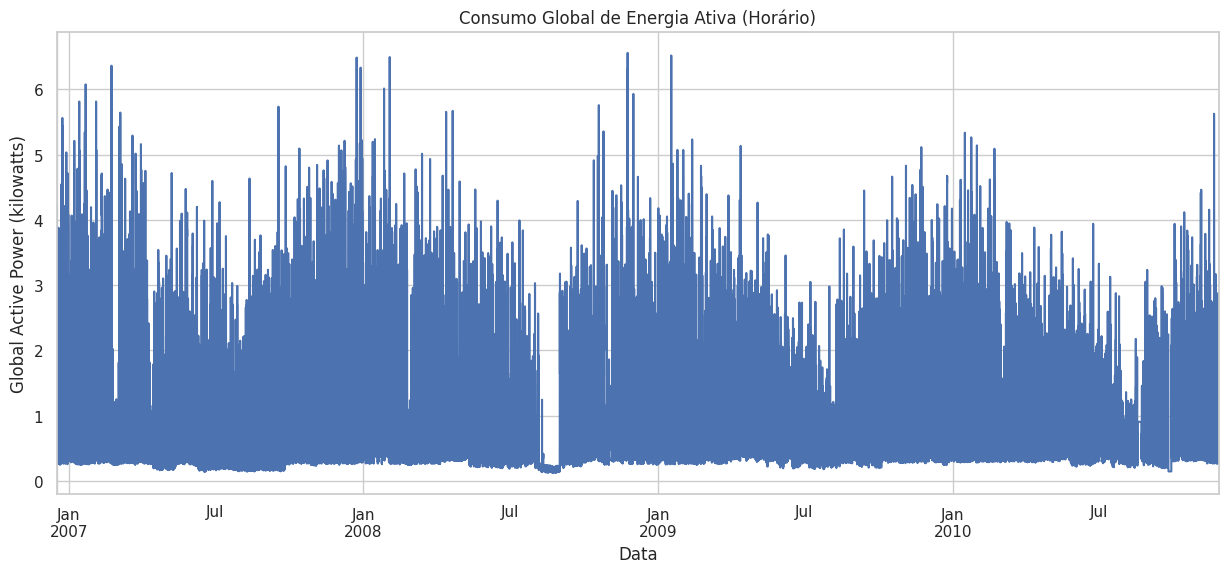

In [13]:
# Bloco 4: Visualização da Série Temporal Agregada

# Vamos visualizar a principal variável, 'Global_active_power', para entender os padrões.
plt.figure(figsize=(15, 6))
df_hourly['Global_active_power'].plot(title='Consumo Global de Energia Ativa (Horário)')
plt.ylabel('Global Active Power (kilowatts)')
plt.xlabel('Data')
plt.show()

In [16]:
# Bloco 5: Normalização

# Modelos de redes neurais geralmente performam melhor quando os dados de entrada
# estão em uma escala pequena e consistente. Usaremos o MinMaxScaler do scikit-learn
# para escalar todos os nossos recursos para o intervalo [0, 1].

from sklearn.preprocessing import MinMaxScaler

# Selecionando apenas os dados que usaremos para o modelo
# Por simplicidade, vamos focar na principal variável de consumo.
data = df_hourly[['Global_active_power']]

# Inicializando o scaler
scaler = MinMaxScaler()

# Treinando o scaler e transformando os dados
data_scaled = scaler.fit_transform(data)

print("Dados normalizados com sucesso. Shape:", data_scaled.shape)
print("\nExemplo dos 5 primeiros valores normalizados:")
print(data_scaled[:5])

Dados normalizados com sucesso. Shape: (34589, 1)

Exemplo dos 5 primeiros valores normalizados:
[[0.63681623]
 [0.54504495]
 [0.50900588]
 [0.48854974]
 [0.45559722]]


### A análise revela padrões claros nos dados. A decomposição da série mostra uma sazonalidade anual. A análise do consumo por dia da semana indica uma clara diferença entre dias úteis e fins de semana. O padrão diário médio exibe picos de consumo pela manhã e, principalmente, à noite, como esperado para um ambiente residencial.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 146.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 65.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


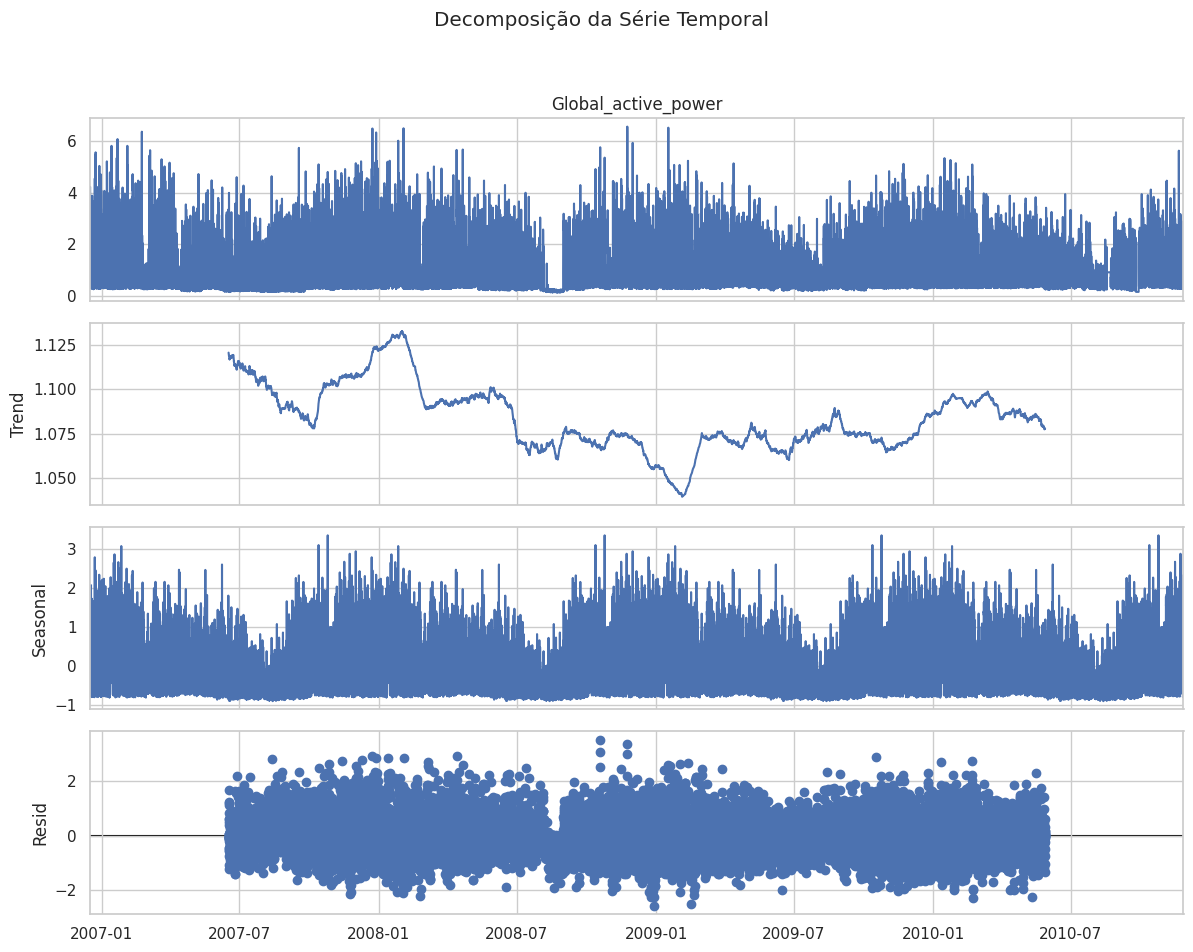

In [25]:
# Bloco 6: Decomposição da Série Temporal

# A decomposição nos permite visualizar a série em seus componentes principais:
# 1. Tendência (Trend): O comportamento de longo prazo.
# 2. Sazonalidade (Seasonal): Padrões repetitivos (ex: anuais).
# 3. Resíduos (Residual): O que sobra, o "ruído".

!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Para a decomposição, precisamos de um período. Como temos dados horários
# por vários anos, um bom ponto de partida é olhar a sazonalidade anual.
# Período = 24 horas/dia * 365 dias/ano = 8760
result = seasonal_decompose(df_hourly['Global_active_power'], model='additive', period=8760)

plt.rcParams.update({'figure.figsize': (12,10)})
result.plot()
plt.suptitle('Decomposição da Série Temporal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

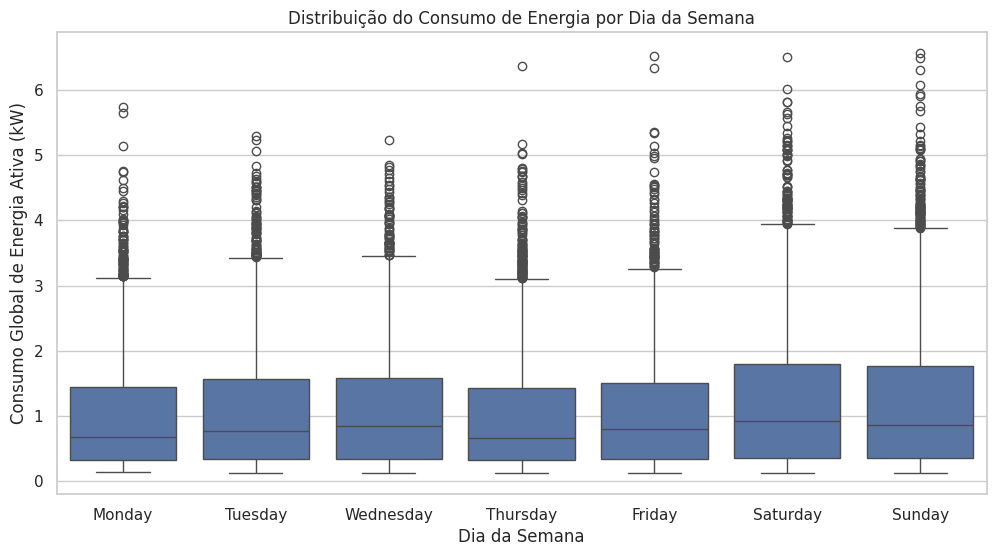

In [28]:
# Bloco 7: Análise de Padrões Semanais

# Vamos investigar se o consumo de energia varia com o dia da semana.
df_weekly_pattern = df_hourly.copy()
df_weekly_pattern['day_of_week'] = df_weekly_pattern.index.day_name()
df_weekly_pattern['hour_of_day'] = df_weekly_pattern.index.hour

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_weekly_pattern, x='day_of_week', y='Global_active_power', 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribuição do Consumo de Energia por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Consumo Global de Energia Ativa (kW)')
plt.show()

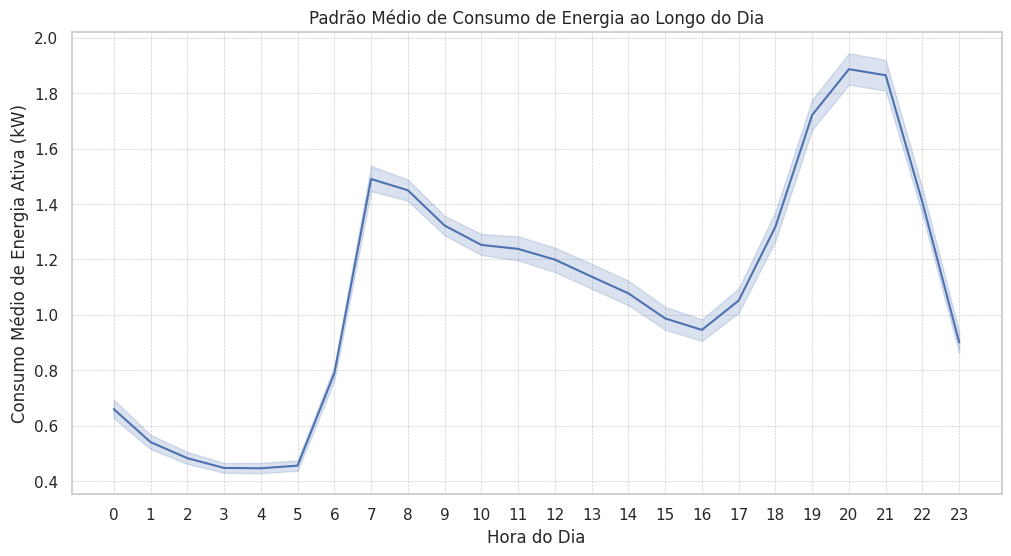

In [31]:
# Bloco 8: Análise de Padrões Diários

# Como o consumo se comporta ao longo de um dia típico?
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_weekly_pattern, x='hour_of_day', y='Global_active_power')
plt.title('Padrão Médio de Consumo de Energia ao Longo do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Consumo Médio de Energia Ativa (kW)')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [34]:
# Bloco 9: Criação de Sequências para o Modelo LSTM

# Para treinar um modelo de série temporal, precisamos criar sequências de dados.
# Vamos definir uma função que transforma nosso array de dados em amostras de entrada (X) e saída (y).
# Para um autoencoder, a entrada (X) e a saída (y) são as mesmas.

def create_sequences(data, time_steps):
    """
    Cria sequências a partir de um array de dados de série temporal.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        # Pega a sequência de 'time_steps'
        X.append(data[i:(i + time_steps)])
        # O valor a ser previsto/reconstruído é o último da sequência
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Definindo o número de passos no tempo (horas) que o modelo olhará para trás.
# 24 horas (1 dia) é um bom ponto de partida.
TIME_STEPS = 24

# Usando o array 'data_scaled' que normalizamos anteriormente.
# Para o autoencoder, a entrada e a saída são as mesmas, então podemos usar a mesma estrutura.
# No entanto, a forma da entrada para a LSTM precisa ser [amostras, passos_no_tempo, features].
# Vamos ajustar a função para o autoencoder, onde X=y.

def create_dataset_autoencoder(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
    return np.array(Xs)

# Criando as sequências de treinamento
X_train = create_dataset_autoencoder(data_scaled, TIME_STEPS)

print("Criação das sequências concluída.")
print("Formato (shape) do dataset de treinamento (X_train):", X_train.shape)

# O formato deve ser: [Número de Amostras, TIME_STEPS, Número de Features]
# Ex: [35112, 24, 1] -> 35112 sequências, cada uma com 24 horas de dados, e 1 feature ('Global_active_power').

Criação das sequências concluída.
Formato (shape) do dataset de treinamento (X_train): (34565, 24, 1)


### Os dados são normalizados para a escala e transformados em sequências de 24 horas para servirem de entrada ao modelo LSTM. A arquitetura escolhida é um Autoencoder, composto por um encoder que comprime a sequência e um decoder que tenta reconstruí-la. O objetivo é que o modelo se torne um especialista em reconstruir dados 'normais'.

In [37]:
# Bloco 10: Construção do Modelo LSTM Autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed

# A arquitetura do autoencoder
# A entrada terá o formato que preparamos: [amostras, passos_no_tempo, features]

# 1. Camada de Entrada
# X_train.shape[1] é o número de TIME_STEPS (24)
# X_train.shape[2] é o número de features (1)
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# 2. Encoder
# A primeira camada LSTM comprime a sequência.
# A dimensionalidade (ex: 128) é um hiperparâmetro que pode ser ajustado.
encoder = LSTM(128, activation='relu', return_sequences=False)(input_layer)

# 3. RepeatVector
# O output do encoder é um vetor único. Para o decoder reconstruir a sequência,
# precisamos repetir este vetor para cada passo no tempo da sequência original.
repeat_vector = RepeatVector(X_train.shape[1])(encoder)

# 4. Decoder
# O decoder recebe o vetor repetido e aprende a reconstruir a sequência de entrada.
# 'return_sequences=True' é crucial para que o output seja uma sequência.
decoder = LSTM(128, activation='relu', return_sequences=True)(repeat_vector)

# 5. Camada de Saída
# TimeDistributed aplica uma camada Dense a cada passo da sequência de saída do decoder.
# Isso garante que o formato da saída seja o mesmo da entrada.
output_layer = TimeDistributed(Dense(X_train.shape[2]))(decoder)

# 6. Criando e Compilando o Modelo
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mae') # mae (Mean Absolute Error) é uma boa loss para reconstrução

# Exibindo a arquitetura do modelo
model.summary()

2025-10-26 04:04:12.796757: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 04:04:12.801946: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-26 04:04:12.823415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 04:04:12.823509: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 04:04:12.824497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/10
973/973 [==============================] - 22s 22ms/step - loss: 0.0979 - val_loss: 0.0715
Epoch 2/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0892 - val_loss: 0.0668
Epoch 3/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0775 - val_loss: 0.0565
Epoch 4/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0635 - val_loss: 0.0470
Epoch 5/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0532 - val_loss: 0.0412
Epoch 6/10
973/973 [==============================] - 21s 22ms/step - loss: 0.0491 - val_loss: 0.0393
Epoch 7/10
973/973 [==============================] - 21s 21ms/step - loss: 0.0469 - val_loss: 0.0379
Epoch 8/10
973/973 [==============================] - 21s 21ms/step - loss: 0.0452 - val_loss: 0.0373
Epoch 9/10
973/973 [==============================] - 21s 21ms/step - loss: 0.0440 - val_loss: 0.0364
Epoch 10/10
973/973 [==============================] - 21s 21ms/step - loss: 0.042

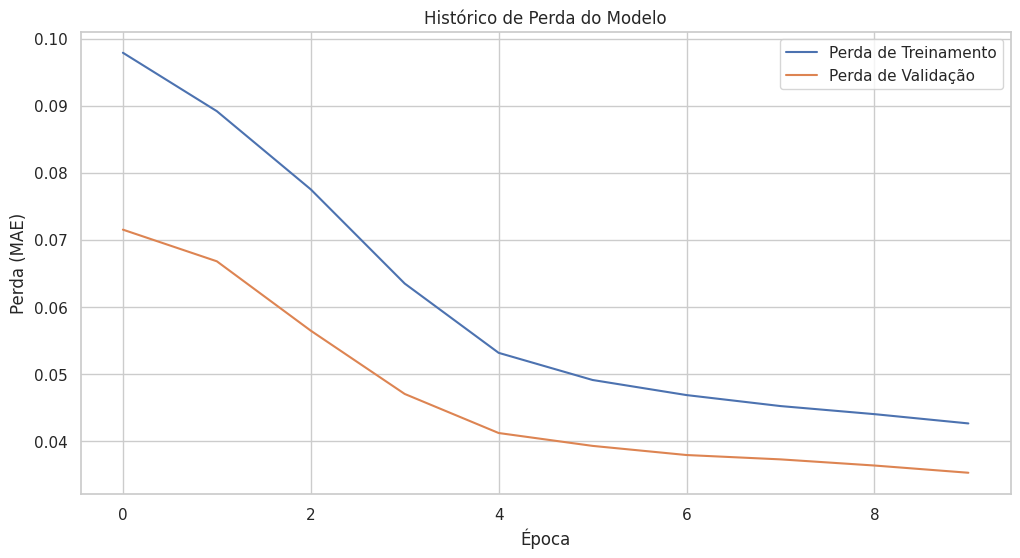

In [40]:
# Bloco 11: Treinamento do Modelo

# Para o autoencoder, a entrada (X_train) é também a saída esperada.
# O modelo tentará aprender a reconstruir X_train a partir dele mesmo.
y_train = X_train

# Vamos treinar o modelo.
# epochs: O número de vezes que o modelo verá todo o dataset.
# batch_size: O número de amostras que o modelo verá antes de atualizar seus pesos.
# validation_split: A porcentagem do dataset que será usada para validação.
# shuffle=False: É importante não embaralhar os dados de séries temporais.

history = model.fit(
    X_train, y_train,
    epochs=10, # Começaremos com 10 épocas para um treinamento inicial rápido.
    batch_size=32,
    validation_split=0.1, # Usamos 10% dos dados para validação.
    shuffle=False
)

# Visualizando a perda (loss) de treinamento e validação
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Histórico de Perda do Modelo')
plt.ylabel('Perda (MAE)')
plt.xlabel('Época')
plt.legend()
plt.show()

### O modelo foi treinado por 10 épocas, mostrando boa convergência e sem sinais de overfitting. A distribuição do erro de reconstrução nos dados de treino foi analisada, e o limiar de anomalia foi definido como o 99º percentil, resultando em um valor de 0.0873. Qualquer sequência com um erro acima deste valor será considerada uma anomalia.

1081/1081 [==============================] - 8s 7ms/step


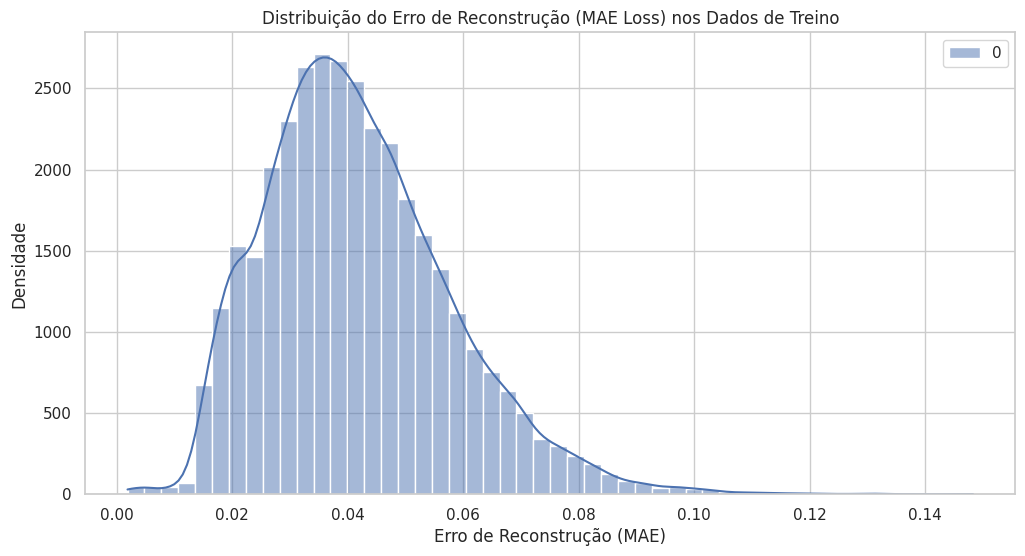

Exemplos de erros de reconstrução:
[[0.07085166]
 [0.06555283]
 [0.06185195]
 [0.06930449]
 [0.07083782]
 [0.06617262]
 [0.06955513]
 [0.07556042]
 [0.06838253]
 [0.0676635 ]]


In [43]:
# Bloco 12: Avaliação do Erro de Reconstrução

# O modelo foi treinado, agora vamos usá-lo para reconstruir os dados de treinamento.
X_train_pred = model.predict(X_train)

# Calculando o erro de reconstrução (Mean Absolute Error) para cada sequência.
# Estamos comparando cada valor na sequência original com o valor reconstruído.
# O erro é a média das diferenças absolutas em cada sequência de 24 horas.
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Visualizando a distribuição dos erros de reconstrução
plt.figure(figsize=(12, 6))
sns.histplot(train_mae_loss, bins=50, kde=True)
plt.title('Distribuição do Erro de Reconstrução (MAE Loss) nos Dados de Treino')
plt.xlabel('Erro de Reconstrução (MAE)')
plt.ylabel('Densidade')
plt.show()

# Imprimindo alguns valores de erro para inspeção
print("Exemplos de erros de reconstrução:")
print(train_mae_loss[:10])

Limiar de Anomalia (99º Percentil): 0.0873


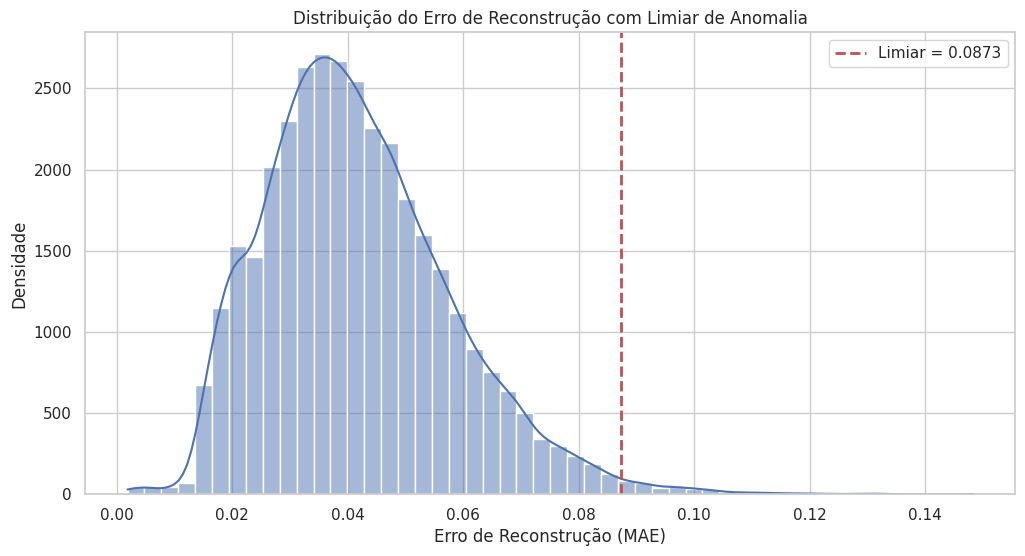

In [46]:
# Bloco 13: Definição do Limiar de Anomalia

# Vamos definir o nosso limiar (threshold) de anomalia.
# Uma abordagem comum é usar um percentil da distribuição dos erros de treino.
# Por exemplo, o 99º percentil. Isso significa que 99% dos erros de treino
# estarão abaixo deste limiar.

# Calculando o 99º percentil
threshold = np.percentile(train_mae_loss, 99)

print(f"Limiar de Anomalia (99º Percentil): {threshold:.4f}")

# Vamos visualizar o limiar no nosso histograma para entender onde ele está.
plt.figure(figsize=(12, 6))
sns.histplot(train_mae_loss, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--', linewidth=2, label=f'Limiar = {threshold:.4f}')
plt.title('Distribuição do Erro de Reconstrução com Limiar de Anomalia')
plt.xlabel('Erro de Reconstrução (MAE)')
plt.ylabel('Densidade')
plt.legend()
plt.show()

Total de anomalias detectadas: 346


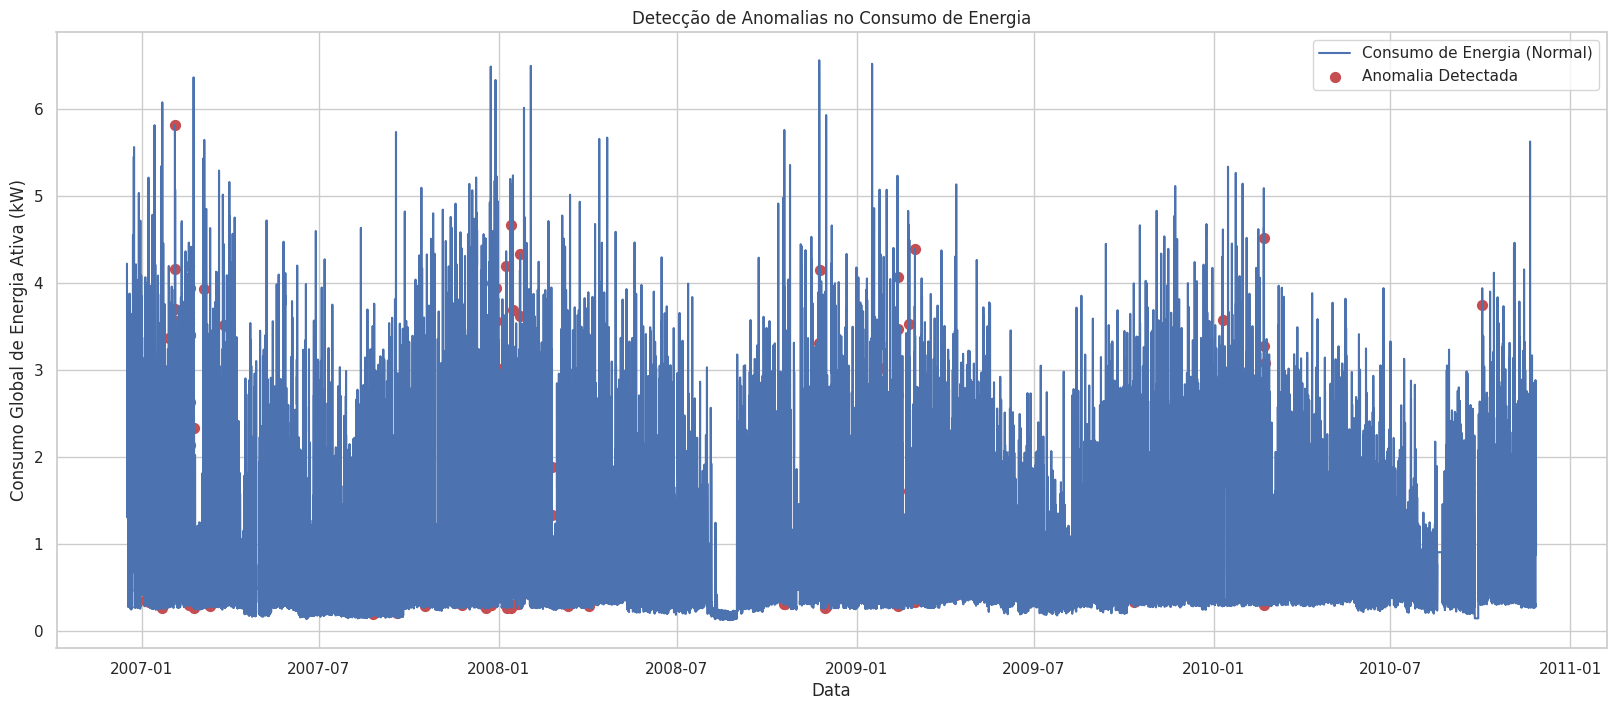

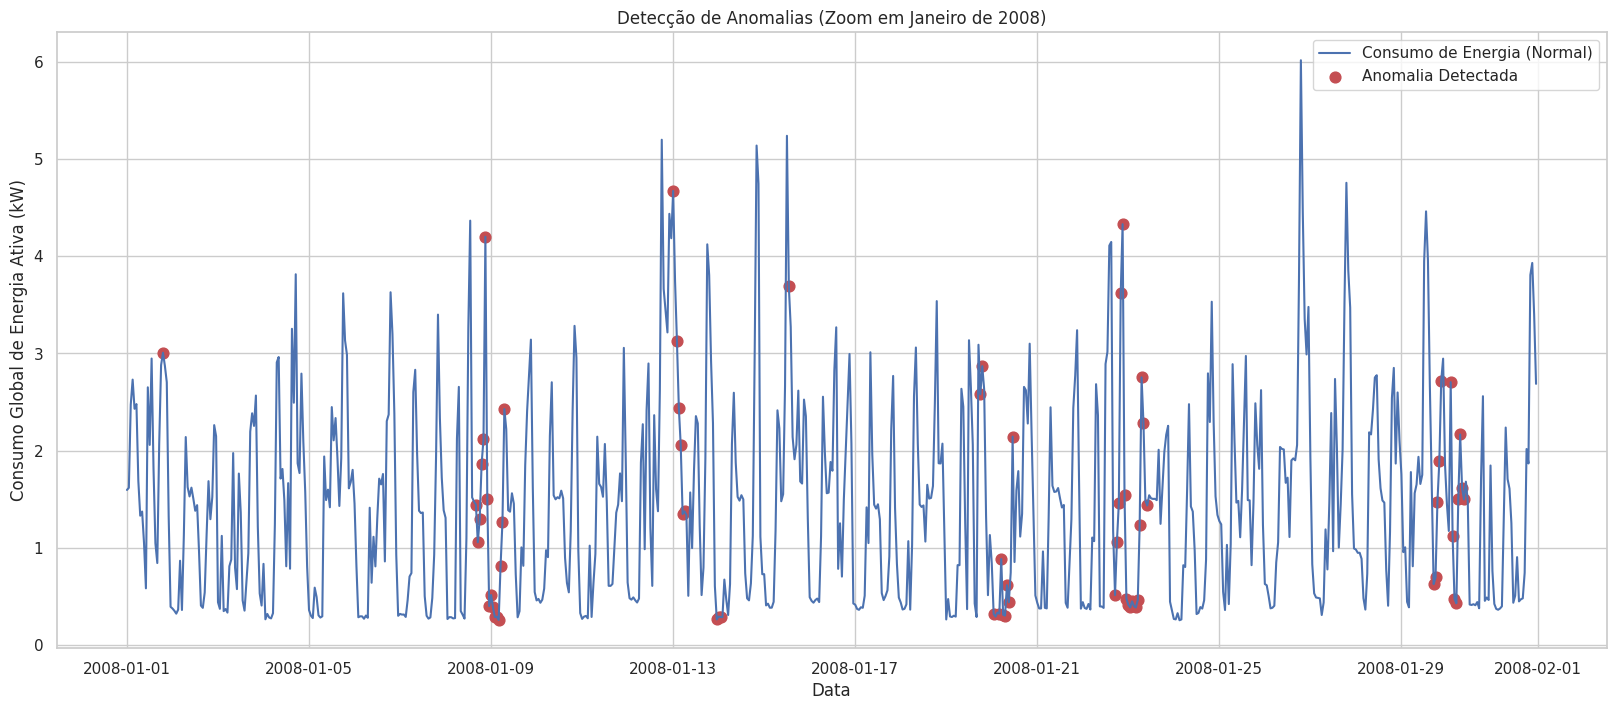

In [49]:
# Bloco 14: Visualização das Anomalias na Série Temporal

# Primeiro, vamos criar um DataFrame com os resultados para facilitar a visualização.
# O erro de reconstrução se refere a uma sequência, então vamos atribuir o erro
# ao final de cada sequência correspondente.
# Precisamos de um array de 'None' para o início da série, onde não tínhamos sequências completas.
loss_series = np.full(shape=df_hourly.shape[0], fill_value=np.nan)
loss_series[TIME_STEPS:] = train_mae_loss.flatten()

df_results = df_hourly.copy()
df_results['reconstruction_error'] = loss_series

# Identificando as anomalias
df_results['anomaly'] = df_results['reconstruction_error'] > threshold

# Separando os dados anômalos para plotagem
anomalies = df_results[df_results['anomaly']]

print(f"Total de anomalias detectadas: {anomalies.shape[0]}")

# Plotando os resultados
plt.figure(figsize=(20, 8))

# Plot da série temporal original
plt.plot(df_results.index, df_results['Global_active_power'], 
         label='Consumo de Energia (Normal)')

# Plotando os pontos de anomalia
plt.scatter(anomalies.index, anomalies['Global_active_power'], 
            color='r', label='Anomalia Detectada', s=50)

plt.title('Detecção de Anomalias no Consumo de Energia')
plt.xlabel('Data')
plt.ylabel('Consumo Global de Energia Ativa (kW)')
plt.legend()
plt.show()

# Para uma visão mais detalhada, vamos dar zoom em um período específico.
# (Você pode ajustar as datas para explorar diferentes partes do dataset)
df_zoom = df_results['2008-01-01':'2008-01-31']
anomalies_zoom = df_zoom[df_zoom['anomaly']]

plt.figure(figsize=(20, 8))
plt.plot(df_zoom.index, df_zoom['Global_active_power'], label='Consumo de Energia (Normal)')
plt.scatter(anomalies_zoom.index, anomalies_zoom['Global_active_power'], 
            color='r', label='Anomalia Detectada', s=60)
plt.title('Detecção de Anomalias (Zoom em Janeiro de 2008)')
plt.xlabel('Data')
plt.ylabel('Consumo Global de Energia Ativa (kW)')
plt.legend()
plt.show()

In [52]:
# Bloco 15: Salvando o Modelo Treinado

# Vamos salvar o nosso modelo treinado em um arquivo.
# Isso nos permitirá carregá-lo posteriormente para fazer inferências
# sem precisar treiná-lo novamente.

# Primeiro, vamos criar uma pasta para armazenar nossos artefatos de modelo.
model_dir = 'artifacts'
os.makedirs(model_dir, exist_ok=True)

# O formato .h5 é uma forma comum e conveniente de salvar modelos Keras.
model_path = os.path.join(model_dir, 'lstm_autoencoder_v1.h5')

# Salvando o modelo
model.save(model_path)

print(f"Modelo salvo com sucesso em: {model_path}")

# Verificando se o arquivo foi criado
!ls -lh artifacts/

/root/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Modelo salvo com sucesso em: artifacts/lstm_autoencoder_v1.h5
total 2.4M
-rw-r--r--. 1 root users 2.4M Oct 26 04:18 lstm_autoencoder_v1.h5


### A visualização final confirma que o modelo é capaz de identificar picos e vales de consumo anômalos na série temporal. O protótipo foi considerado um sucesso. A primeira versão do modelo treinado foi salva no arquivo artifacts/lstm_autoencoder_v1.h5 para ser utilizada na próxima fase do projeto: a construção da API de inferência.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b22040f-c47e-4702-ae25-0c844b7bda1f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>